# Model Klasifikasi Produk Keuangan Berdasarkan Keluhan yang Diterima

**Disampaikan oleh Dr. Juliho Castillo**.

Dalam proyek ini, saya akan menganalisis kumpulan data [Keluhan Konsumen](https://www.kaggle.com/dushyantv/consumer_complaints), yang mencakup keluhan yang diterima terhadap lembaga keuangan di Amerika Serikat selama periode 2012 hingga 2016.

Pada bagian pertama dari pekerjaan ini, saya akan memanipulasi dan membersihkan data sehingga berguna untuk analisis. Pada bagian kedua, saya akan menganalisis data ini baik dalam dimensinya maupun perilaku temporalnya, untuk akhirnya membuat model yang memungkinkan saya memprediksi kategori produk berdasarkan karakteristik lainnya.

Karena keterbatasan waktu dan sumber daya, saya akan menggunakan sampel dari seluruh kumpulan data. Namun, parameter yang digunakan untuk memilih sampel ini dapat dengan mudah diubah sehingga algoritme berlaku untuk seluruh kumpulan data.

# Praproses Data

## Mengimpor Modul dan Data

- Mari mengimpor modul yang akan digunakan selama proyek
- Kita periksa apakah GPU tersedia
- Kita impor data ke dalam kerangka data df.

In [6]:
import pandas as pd
import numpy as np
import string
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns


#!pip install xgboost
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

#!pip install plotly
import plotly.offline as py
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

warnings.filterwarnings("ignore")

### Download Dataset 
Dataset ini berisi keluhan konsumen terkait layanan keuangan, dikumpulkan oleh CFPB (*Consumer Financial Protection Bureau*).
[Kaggle - Consumer Complaint Database](https://www.kaggle.com/datasets/selener/consumer-complaint-database)  


In [7]:
df = pd.read_csv('../Data/Consumer_Complaints.csv')
rows = df.shape[0]

* Karena keterbatasan memori, kami akan mengambil sampel dari basis data.
* Persentase tertinggi (dibulatkan) yang dapat digunakan adalah 35%.
* Variabel 'samples' memberi tahu kita berapa banyak rekaman yang terdapat dalam sampel kita.
* Setelah mengimpor kerangka data, kita diperlihatkan peringatan tentang dua kolom ini. Kita akan membahasnya nanti.
* Fungsi `cool_col` akan mengubah nama setiap kolom sehingga lebih mudah digunakan.
* Kita mengubah nama semua kolom.
* Variabel ubanks adalah kumpulan nama bank yang diurutkan berdasarkan abjad.

In [8]:
pct = 0.15
magic_number = int(pct*rows)
df = df.sample(n=magic_number, random_state=0)
samples = df.shape[0]

In [9]:
df.columns[[5,11]]

Index(['Consumer Complaint', 'Consumer consent provided?'], dtype='object')

In [10]:

def cool_col(col):
    col = col.replace("-", " ")
    col = col.replace("?", "")
    phrase = col.split()
    tag = None
    if len(phrase)==1:
        tag = phrase[0]
    else:
        tag = phrase[0]+"_"+phrase[1]    
    #print(col, phrase, tag)
    return tag.lower()

In [11]:

df.columns = [cool_col(col) for col in df.columns]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153751 entries, 875832 to 931343
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date_received       153751 non-null  object 
 1   product             153751 non-null  object 
 2   sub_product         118500 non-null  object 
 3   issue               153751 non-null  object 
 4   sub_issue           79482 non-null   object 
 5   consumer_complaint  41762 non-null   object 
 6   company_public      47357 non-null   object 
 7   company             153751 non-null  object 
 8   state               151935 non-null  object 
 9   zip_code            151277 non-null  object 
 10  tags                21347 non-null   object 
 11  consumer_consent    73876 non-null   object 
 12  submitted_via       153751 non-null  object 
 13  date_sent           153751 non-null  object 
 14  company_response    153750 non-null  object 
 15  timely_response     153751 non-nul

In [13]:

ubanks = np.sort(pd.unique(df["company"]))

## Pemrosesan Variabel

- Saya akan menghapus ID keluhan karena tidak memberikan informasi yang relevan.
- Saya hanya akan bekerja dengan variabel yang memiliki nilai null kurang dari 20%.

In [14]:

df.drop(columns = ['complaint_id'], inplace=True)

In [15]:
to_include = df.columns[(df.isnull().sum()<(0.20)*samples).values]

In [16]:
to_include

Index(['date_received', 'product', 'issue', 'company', 'state', 'zip_code',
       'submitted_via', 'date_sent', 'company_response', 'timely_response'],
      dtype='object')

In [17]:
df = df[to_include]

### Perusahaan

- Sekarang kita akan mengubah variabel "perusahaan", mencoba mengidentifikasi bank-bank yang termasuk dalam kelompok yang sama dan yang namanya bervariasi dalam keadaan tertentu.
- Misalnya, karena mereka berlokasi di dua negara bagian yang berbeda.
- Kita mengidentifikasi karakter khusus yang akan diganti.
- Kita mencari sufiks yang paling umum.

In [18]:
non_special = {ord(c):"" for c in string.punctuation}

In [19]:

common_suffixes = set()
for bank in ubanks[0]:
    if "," in bank:
        last_comma = bank.rindex(",")       
        suffix = bank[last_comma+1:].strip()
        suffix_words = suffix.split()
        if "&" not in suffix_words and "and" not in suffix_words:
           common_suffixes.add(suffix)           
#common_suffixes.remove("")
common_suffixes = sorted(common_suffixes, key=len)[::-1]

- Fungsi ini akan membantu kita membersihkan nama bank untuk mengidentifikasi nama-nama yang mirip.

- Kamus `bank_tags` akan memberi kita cara untuk mengidentifikasi setiap nama bank asli dengan nama yang bersih.

- Kita mengganti nama-nama bank dengan kamus sebelumnya.

In [20]:

def clean_title(title):
    title = title.translate(non_special).lower()
    title = title.replace("the", "")
    title = title.replace("of", "")
    title = title.replace("&", "")
    title = title.replace("and", "")
    title = "_".join([word for word in title.split() if len(word)>1])
    return title

In [21]:

bank_tags = {}
for bank in ubanks:
    new = bank
    for suffix in common_suffixes:
        new = new.replace(suffix, "")
    if clean_title(new):
        bank_tags[bank] = clean_title(new)
    else:
        tag = bank.split()[0].translate(non_special).lower()      
        #print("{:<30} {:<10} {} {:>10}".format(bank,new,clean_title(new),tag))                
        bank_tags[bank] = tag

In [22]:

df.company=df["company"].replace(bank_tags)

### Tanggal diterima/Tanggal dikirim ke perusahaan

- Saya mengubah tanggal penerimaan pengaduan dari tipe string ke tipe stempel waktu.
- Saya mengubah tanggal pengajuan pengaduan ke bank dari tipe string ke tipe stempel waktu.
- Saya mencari tanggal terbaru dalam bingkai data.
- Kolom data baru ini berisi jumlah hari yang telah berlalu sejak pengaduan diterima hingga tanggal terbaru.
- Kolom data baru ini berisi jumlah hari yang telah berlalu sejak pengaduan dikirim ke bank hingga tanggal terbaru.

In [23]:

df["date_received"] = df["date_received"].str.replace('/', '-')
df.date_received = pd.to_datetime(df["date_received"])

In [24]:

df["date_sent"] = df["date_sent"].str.replace('/', '-')
df.date_sent = pd.to_datetime(df["date_sent"], format="%m-%d-%Y")

In [25]:

today = max(df.date_received.max(), df.date_sent.max())

In [26]:

df["received_days"] = (today-df.date_received)/np.timedelta64(1, 'D')

In [27]:

df["sent_days"] = (today-df.date_sent)/np.timedelta64(1, 'D')

## Transformasi ke Variabel Kategori
### Variabel Objek
- Kita mengidentifikasi variabel tipe objek
- Kita membuat matriks yang hanya menyertakan variabel tipe objek
- Kita membuat matriks yang hanya menyertakan variabel tipe objek
- Kita mengubah semua variabel menjadi kategori.

In [28]:

df.select_dtypes(include=['object']).columns

Index(['product', 'issue', 'company', 'state', 'zip_code', 'submitted_via',
       'company_response', 'timely_response'],
      dtype='object')

In [29]:

X = df.select_dtypes(include=['object'])

In [30]:
X.drop(columns = ["product"], inplace=True)

In [31]:

X = X.astype('category')

### Variabel Numerik
- Kita mengidentifikasi variabel numerik
- Kita menambahkan variabel ini ke matriks kita
- Kita memeriksa berapa banyak nilai null yang dimiliki kolom kita.

In [32]:
df._get_numeric_data().columns

Index(['received_days', 'sent_days'], dtype='object')

In [33]:

X = pd.concat([X,df._get_numeric_data()], axis=1)

In [34]:

X.isnull().sum()

issue                  0
company                0
state               1816
zip_code            2474
submitted_via          0
company_response       1
timely_response        0
received_days          0
sent_days              0
dtype: int64

Kita pisahkan setiap variabel numerik ke dalam kuartil. Kategori setiap catatan akan sesuai dengan kuartilnya. Ini akan memungkinkan kita untuk menjadikan semua catatan sebagai variabel kategoris yang nantinya akan kita ubah menjadi vektor biner.

In [35]:

for col in df._get_numeric_data().columns:
    X[col] = pd.qcut(X[col], 4).astype("category")

## Pengodean
Kita akan mengodekan kategori setiap kolom sebagai bilangan asli.

In [36]:
encoder = {}
for col in X.columns:
    encoder[col] = preprocessing.LabelEncoder()
    temp = X[col].values
    X[col] = encoder[col].fit_transform(temp)

### Pengodean OneHot
Karena keterbatasan memori, Saya hanya akan bekerja dengan tiga variabel prediktor. Variabel-variabel ini dipilih secara manual, untuk mengilustrasikan cara memvisualisasikan dan menganalisis data. Namun, variabel-variabel tersebut dapat dipilih secara objektif menggunakan metode seperti RFE (Recursive Feature Elimination).
- Saya akan mengubah variabel kategoris menjadi vektor biner.
- Saya akan melakukan hal serupa dengan kerangka data.
- Terakhir, Saya akan membuat kolom tambahan yang akan membantu Saya menghitung.

In [37]:
to_select = ['issue', 'company', 'received_days']

In [38]:
X = X[to_select]

In [39]:
ohc = preprocessing.OneHotEncoder(sparse_output = False)
X = ohc.fit_transform(X.values)

In [40]:
df = df[to_select+["product", "date_received", "state"]]

In [41]:
df["count"] = 1

## Pemrosesan Respons
- Saya menyimpan kolom target di target
- Saya memverifikasi bahwa tidak ada nilai null dalam variabel respons.
- Saya mengodekan variabel respons dan menyimpan transformasi dalam variabel y
- Karena keterbatasan memori, Saya akan menghilangkan seri target.

In [42]:
target = df["product"]

In [43]:
target.isnull().sum()

0

In [44]:
encoder["product"] = preprocessing.LabelEncoder()
y = encoder["product"].fit_transform(target)

In [45]:
del target

## Set Pelatihan dan Pengujian
- Saya memisahkan matriks prediktor dan vektor respons ke dalam set pengujian dan pelatihan.
- Karena keterbatasan memori, kami akan menghilangkan matriks X dan matriks y.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [47]:
del X

In [48]:
del y

# Modeling 

## Persyaratan

- Sajikan satu atau beberapa statistik deskriptif yang memberikan gambaran tentang perilaku data (dari waktu ke waktu, dalam ruang, dalam kedua dimensi; berdasarkan nama bank, jenis pengaduan, dll.)
- Statistik harus disertai dengan penjelasan singkat yang masuk akal.
- Sebagai bagian dari instruksi sebelumnya, buat satu atau beberapa visualisasi yang menurut Anda penting untuk memahami basis data.
- Bersikaplah selektif, sehingga visualisasi Anda menceritakan kisah dengan data. Anda dapat menggunakan visualisasi dinamis (plotly, bokeh, dll.) atau yang statis (matplotlib, seaborn, plotnine, dll.)

### Keluhan Berdasarkan Lokasi

Kita akan memvisualisasikan jumlah keluhan berdasarkan negara bagian. Seperti yang Anda lihat, California adalah negara bagian dengan keluhan terbanyak.

In [49]:
states = df.groupby(["state"]).count()[["issue"]]

In [50]:
states["issue"]

state
AA       2
AE      65
AK     185
AL    1682
AP      45
      ... 
VT     218
WA    3078
WI    1616
WV     394
WY     139
Name: issue, Length: 62, dtype: int64

In [51]:
scl = [[0.0, 'rgb(242,240,247)'],
       [0.2, 'rgb(218,218,235)'],
       [0.4, 'rgb(188,189,220)'],
       [0.6, 'rgb(158,154,200)'],
       [0.8, 'rgb(117,107,177)'],
       [1.0, 'rgb(84,39,143)']]

data = [dict(
        type='choropleth',
        colorscale=scl,
        autocolorscale=False,
        locations=states.index,  # Lokasi negara bagian (AS) diubah sesuai data
        z=states['issue'].astype(float),  # Nilai yang diplot pada peta
        locationmode='USA-states',  # Menggunakan mode AS
        marker=dict(
            line=dict(
                color='rgb(255,255,255)',  # Warna garis pembatas
                width=2
            )
        ),
        colorbar=dict(
            title="Number of Complaints"  # Mengubah "Número de quejas" menjadi "Number of Complaints"
        )
    )]

layout = dict(
    title='Complaints by State',  # Mengubah "Quejas por estado" menjadi "Complaints by State"
    geo=dict(
        scope='usa',  # Mengatur cakupan ke Amerika Serikat
        projection=dict(type='albers usa'),  # Proyeksi Albers khusus USA
        showlakes=True,  # Menampilkan danau di peta
        lakecolor='rgb(255, 255, 255)',  # Warna untuk danau
    ),
)

fig = dict(data=data, layout=layout)

# url = py.iplot(fig, filename='d3-choropleth-map.html')  # Nama file output juga diganti agar lebih deskriptif


### Keluhan Seiring Waktu

- Pertama, mari kita amati distribusi keluhan seiring waktu.
- Kemudian kita akan menganalisis perilaku temporal keluhan menggunakan deret waktu. Untuk mengadaptasinya ke data kita.
- Kita akan memotong data hingga 31 Oktober 2016, karena informasi untuk November tidak lengkap, dan kita tidak memiliki data setelah bulan ini.
- Kita mengelompokkan data berdasarkan tanggal; kita menghitung keluhan per hari dan mengambil sampel ulang berdasarkan bulan.
- Kita akan memvisualisasikan deret waktu
- Kita mencari parameter optimal untuk model SARIMAX kita
- Terakhir, kita memvisualisasikan prakiraan vs data aktual untuk tahun 2016

<Axes: xlabel='date_received', ylabel='Density'>

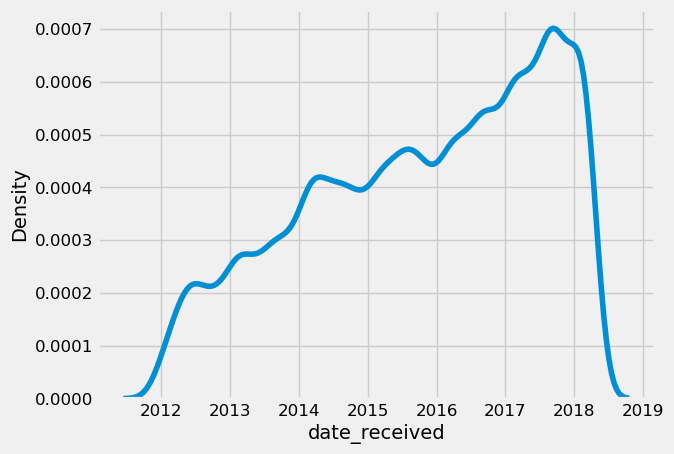

In [52]:
sns.kdeplot(df["date_received"])

In [53]:
top_date = pd.to_datetime('2016-10-31')

In [54]:
ts = df[["date_received", "count"]].groupby("date_received").sum()[:top_date].resample("MS").sum()
ts.tail()

,count
date_received,
2016-06-01,2338
2016-07-01,2414
2016-08-01,2681
2016-09-01,2661
2016-10-01,2696


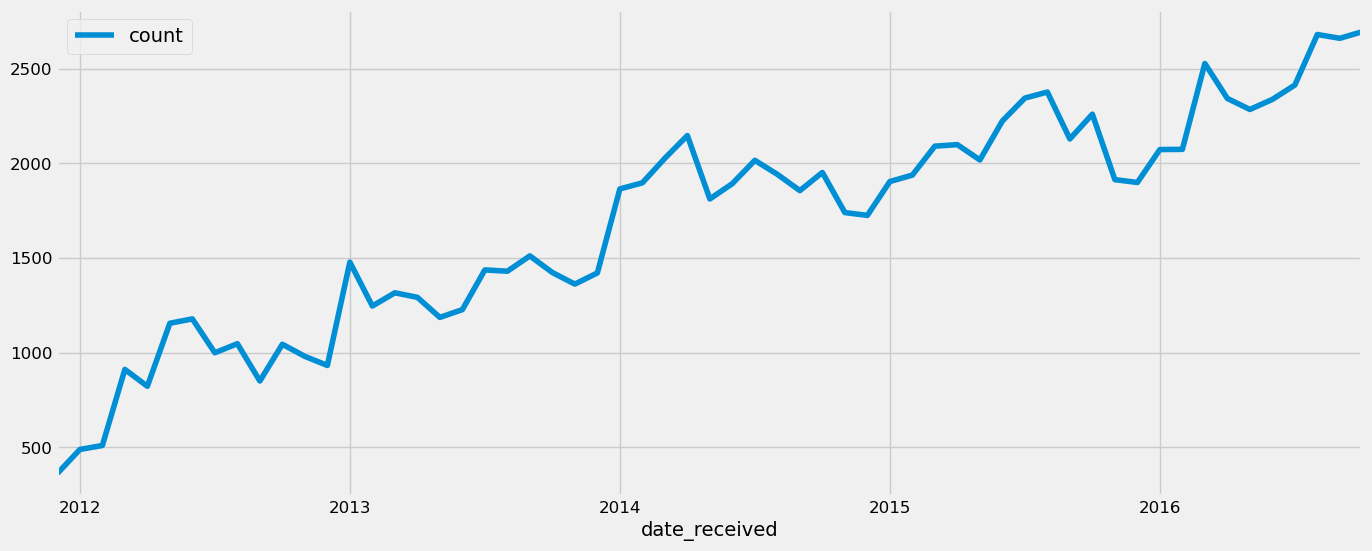

In [55]:
ts.plot(figsize=(15, 6))
plt.show()

In [56]:
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

opt_param = None
opt_param_seasonal = None
opt_results = None
opt_aic = np.inf

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < opt_aic:
                opt_param = param
                opt_param_seasonal = param_seasonal
                opt_results = results
                opt_aic = results.aic
        except:
            continue

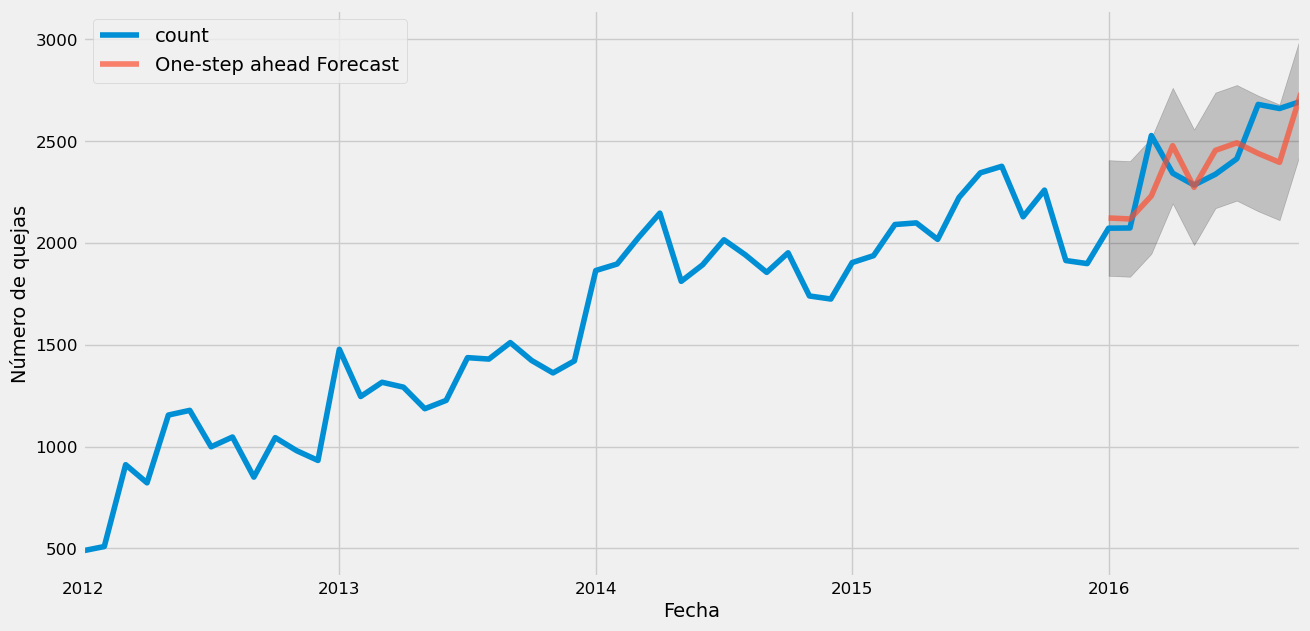

In [57]:
pred = opt_results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de quejas')
plt.legend()
plt.show()

## Frekuensi Keluhan Berdasarkan Bank
Gunakan algoritma "edit-distance" atau algoritma lain yang Anda anggap relevan, normalkan nama-nama bank dan buat diagram batang yang menunjukkan frekuensi keluhan berdasarkan bank.

### Top 10 Complaints by Product

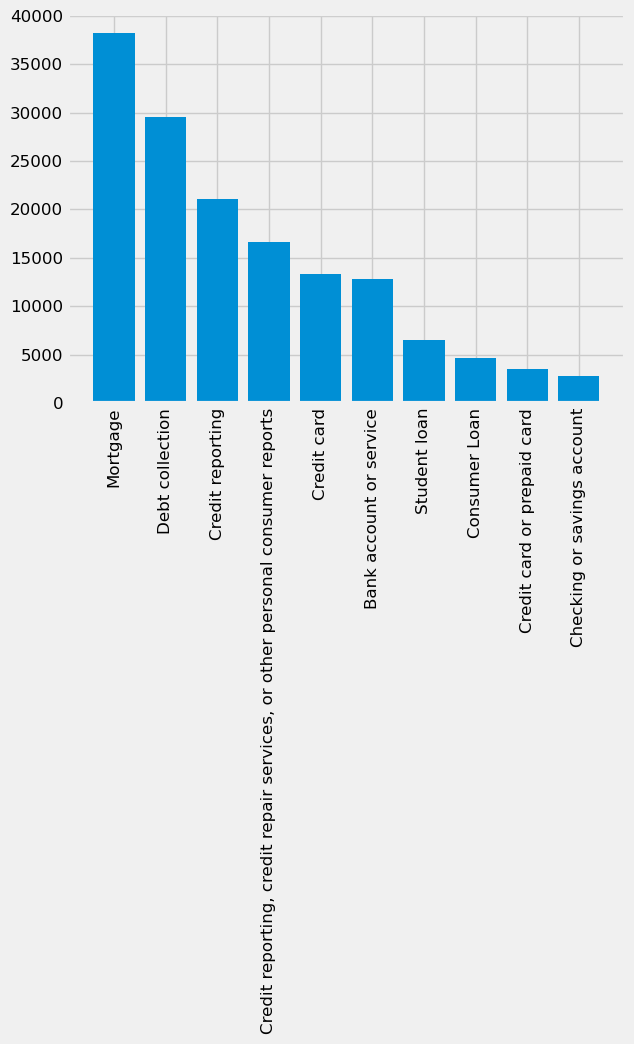

In [58]:
counter = Counter(df["product"])
top10_productos = OrderedDict(counter.most_common(10))
plt.bar(list(top10_productos.keys()), list(top10_productos.values()))
plt.xticks(rotation=90)
plt.show()

### 10 keluhan teratas oleh bank

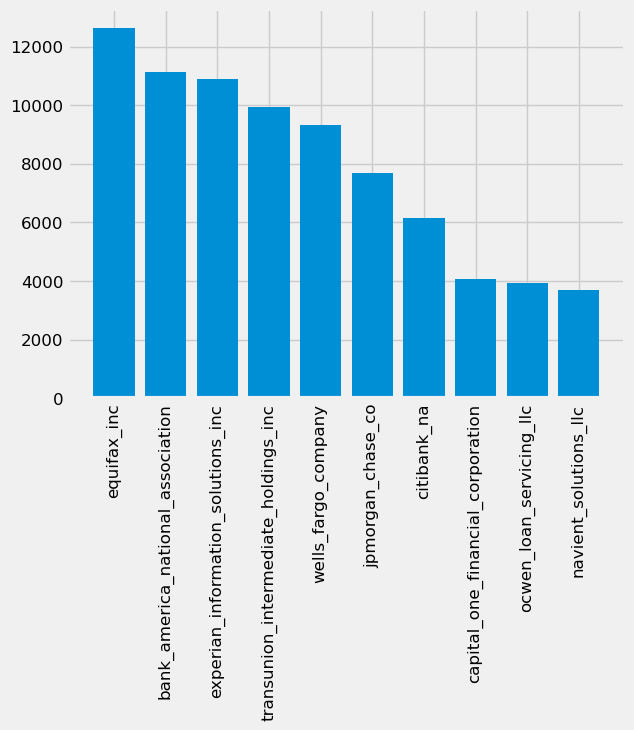

odict_keys(['equifax_inc', 'bank_america_national_association', 'experian_information_solutions_inc', 'transunion_intermediate_holdings_inc', 'wells_fargo_company', 'jpmorgan_chase_co', 'citibank_na', 'capital_one_financial_corporation', 'ocwen_loan_servicing_llc', 'navient_solutions_llc'])

In [59]:
counter = Counter(df["company"])
top10_bancos = OrderedDict(counter.most_common(10))
plt.bar(list(top10_bancos.keys()), list(top10_bancos.values()))
plt.xticks(rotation=90)
plt.show()
top10_bancos.keys()

### 10 keluhan teratas menurut bank/produk

In [60]:
df.groupby(["company", "product"]).count()[["count"]].sort_values(by=["count"], ascending=False).head(n = 10)

,,count
company,product,
equifax_inc,Credit reporting,7231
experian_information_solutions_inc,Credit reporting,6822
bank_america_national_association,Mortgage,6228
transunion_intermediate_holdings_inc,Credit reporting,6004
equifax_inc,"Credit reporting, credit repair services, or other personal consumer reports",5269
wells_fargo_company,Mortgage,5088
experian_information_solutions_inc,"Credit reporting, credit repair services, or other personal consumer reports",3929
transunion_intermediate_holdings_inc,"Credit reporting, credit repair services, or other personal consumer reports",3831
ocwen_loan_servicing_llc,Mortgage,3786


## Topik yang berulang
Topik apa saja yang dibahas dalam pengaduan?

### Sepuluh keluhan teratas berdasarkan subjek

In [61]:
df[["issue", "count"]].groupby(["issue"]).count().sort_values(by=["count"], ascending=False).head(n=10)

,count
issue,
"Loan modification,collection,foreclosure",17018
Incorrect information on credit report,15391
"Loan servicing, payments, escrow account",11480
Incorrect information on your report,9164
Cont'd attempts collect debt not owed,9110
"Account opening, closing, or management",5622
Disclosure verification of debt,4643
Communication tactics,4459
Problem with a credit reporting company's investigation into an existing problem,3695


### Keluhan berdasarkan bank/masalah

In [62]:
pd.pivot_table(df, values="count", index=["company"], columns=["issue"], aggfunc=np.sum, fill_value=0)

issue,APR or interest rate,"Account opening, closing, or management",Account terms and changes,Adding money,Advertising,Advertising and marketing,"Advertising and marketing, including promotional offers","Advertising, marketing or disclosures",Application processing delay,"Application, originator, mortgage broker",...,Unauthorized transactions/trans. issues,Unexpected or other fees,Unexpected/Other fees,Unsolicited issuance of credit card,Using a debit or ATM card,Vehicle was damaged or destroyed the vehicle,Vehicle was repossessed or sold the vehicle,"Was approved for a loan, but didn't receive the money",Written notification about debt,Wrong amount charged or received
company,,,,,,,,,,,,,,,,,,,,,
1st_alliance_lending_llc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st_fidelity_loan_servicing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st_financial_inc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st_franklin_financial_corporation,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st_maryl_mortgage_corporation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zenith_financial_network_inc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zeus_mortgage_ltd,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
zions_bancorporation,0,10,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## Dimensi data
Kembangkan model pembelajaran tanpa pengawasan untuk memahami dimensi data yang dapat dikelompokkan dengan jelas.

### PCA

Pada langkah pertama ini, kita akan melakukan analisis komponen utama dari matriks pelatihan kita. Kita akan memilih dua komponen yang paling baik menjelaskan varians, agar dapat memvisualisasikannya. Setiap data akan diproyeksikan ke dua komponen ini, yang akan memberi kita koordinat untuk pengelompokan.

In [63]:
n,p = X_train.shape
n

123000

In [64]:
pca = PCA(n_components=2)

In [65]:
X_train_sample = X_train[np.random.choice(X_train.shape[0], int(0.10*X_train.shape[0]), replace=False), :]

In [66]:
X_pca = pca.fit_transform(X_train_sample)

In [67]:
explained_ratio = pca.explained_variance_ratio_

In [68]:
np.add.accumulate(explained_ratio)

array([0.10918901, 0.20688126])

In [69]:
e1, e2 = pca.components_

In [70]:
p = len(e1)

### Pengelompokan

Pada langkah kedua ini, kita akan mengelompokkan data, dengan koordinat yang diberikan oleh dua komponen utama, menggunakan algoritma k-means. Kita akan memilih jumlah pengelompokan sesuai dengan diagram distorsi, tepat di titik di mana "siku" grafik terbentuk.

In [71]:
x0 = X_pca[:,0].ravel()

In [72]:
x1 = X_pca[:,1].ravel()

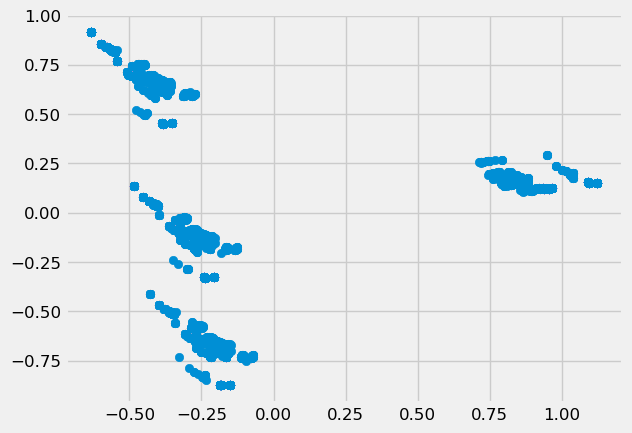

In [73]:
plt.scatter(x0,x1)

In [74]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_pca)
    distortions.append(km.inertia_)

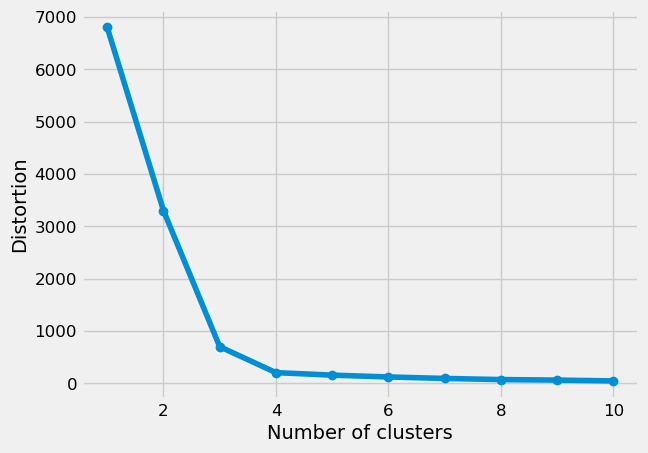

In [75]:
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [76]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_pca)

In [77]:
clusters = kmeans.predict(X_pca).ravel()

<Axes: >

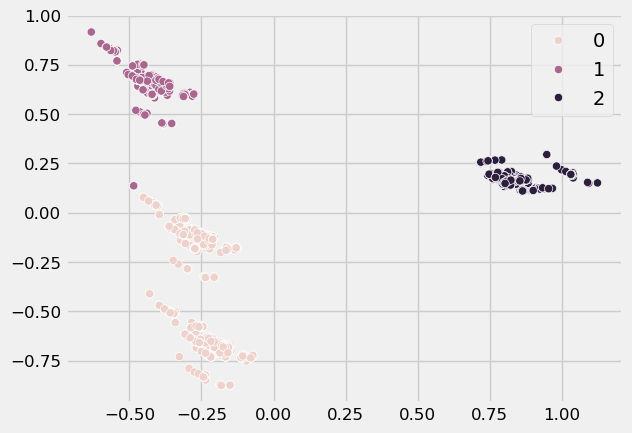

In [78]:
sns.scatterplot(x=x0, y=x1, hue=clusters)

In [79]:
del X_pca

## Prediksi berdasarkan Machine Learning

Kembangkan model pembelajaran mesin yang memprediksi jenis produk berdasarkan teks. Anda dapat menggunakan teknik apa pun yang Anda inginkan, tetapi Anda harus menjelaskan metrik evaluasi apa yang Anda gunakan untuk menentukan pilihan model.

### XGBoost

- Untuk pertanyaan ini, saya memilih pengklasifikasi XGBoost.
- XGBoost adalah algoritme yang baru-baru ini mendominasi pembelajaran mesin terapan dan kompetisi Kaggle untuk data terstruktur atau tabular.
- XGBoost adalah implementasi pohon keputusan berbasis gradien yang dirancang untuk kecepatan dan kinerja.
- Pengklasifikasi XGBoost memiliki implementasi yang mampu menggunakan perangkat GPU, yang akan memungkinkan kita untuk mempercepat pelatihan secara signifikan.

In [80]:

gpu_available = False  # Set False jika hanya ada iGPU atau CPU

if gpu_available:
    xgb_cl = xgb.XGBClassifier(
        use_label_encoder=False,
        tree_method='gpu_hist',
        max_bin=16,
        predictor='gpu_predictor',
        nthread=4
    )
else:
    xgb_cl = xgb.XGBClassifier(
        use_label_encoder=False,
        tree_method='hist', 
        max_bin=256, 
        predictor='cpu_predictor',
        nthread=-1 
    )


In [81]:
xgb.XGBClassifier._repr_html_ = None
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=256,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

### Metrik
Terakhir, saya akan menggunakan berbagai metrik untuk memvalidasi model saya, membandingkan prediksi dengan kategori sebenarnya dari setiap produk.

saya akan menampilkan reporter klasifikasi otomatis. Meskipun di luar cakupan laporan ini untuk menjelaskan setiap metrik, cukup untuk dipahami bahwa semakin dekat setiap metrik dengan 1,00, semakin "baik" modelnya.

Namun, saya akan memberikan perhatian khusus pada [akurasi](https://developers.google.com/machine-learning/crash-course/classification/accuracy), yang tidak lain adalah jumlah prediksi yang benar atas total prediksi yang dibuat.

In [82]:
preds = xgb_cl.predict(X_test)

In [83]:

print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2479
           1       1.00      0.99      0.99       543
           2       0.98      0.99      0.99       959
           3       0.98      0.99      0.99      2657
           4       0.99      0.93      0.96       708
           5       1.00      1.00      1.00      4213
           6       0.96      1.00      0.98      3304
           7       1.00      1.00      1.00      5904
           8       0.98      0.96      0.97       181
           9       0.96      0.99      0.98       161
          10       1.00      0.99      0.99      7717
          11       0.81      0.77      0.79        22
          12       0.95      0.99      0.97       192
          13       0.92      0.75      0.82       126
          14       0.99      0.96      0.97       118
          15       1.00      0.98      0.99      1300
          16       0.91      0.83      0.87       167

    accuracy              

In [84]:
accuracy_score(y_test, preds)

0.9907320087151638

# Kesimpulan

Dalam proyek ini, saya telah membangun sebuah model untuk memprediksi jenis produk yang menjadi sasaran pengaduan, berdasarkan prediktor seperti bank, subjek pengaduan, dan tanggal penerimaan.

Meskipun keterbatasan waktu dan sumber daya komputasi membatasi saya untuk menganalisis sebagian dari kumpulan tersebut, hal ini dapat diatasi dengan mengakses lebih banyak sumber daya, misalnya di cloud, atau menggunakan algoritme yang memungkinkan bekerja dengan data besar, mengadaptasi algoritme tersebut ke paket yang tersedia. Untuk tujuan ini.

Terakhir, model saya memungkinkan akurasi dalam kumpulan pengujian, yang memungkinkan saya untuk berpikir bahwa model tersebut telah menggeneralisasi pola data dengan benar, itulah sebabnya model ini diusulkan sebagai solusi yang layak untuk masalah tersebut.